In [1]:
# Подключаем необходимые библиотеки
import os                                   # Модуль для работы с операционной системой
    
import torch                                # Основной модуль PyTorch 
import torch.nn as nn                       # Модуль PyTorch для работы с нейронными сетями
import torch.utils.data as Data             # Модуль для работы с Dataset'ами

import torchvision                          # Основной модуль PyTorch для работы с изображениями
import torchvision.transforms as transforms # Модуль для преобразования изображений

In [2]:
torch.manual_seed(1)                        # Настраиваем генератор случайных чисел

In [3]:
# Создаем модель нейронной сети:
class CNN( nn.Module ):
    def __init__( self ):
        super( CNN, self ).__init__()
        self.conv1 = nn.Sequential(                   # Первый слой. На вход подается изображение с 3 каналами (RGB), размером 32х32 
                                                      # или (3, 32, 32) 
            nn.Conv2d(                                # Функиця свертки.  
                in_channels  = 3                      # Количество входящих каналов - 3, равно количеству каналов изображения
              , out_channels = 16                     # Количество исходящих каналов - 16
              , kernel_size  = 5                      # Размер ядра свертки - 5
              , stride       = 1                      # Смещение при свертке по горизонтали и вертикали - 1
              , padding      = 2                      # Количество дополнительных столбцов и строк, заполненных нулями, у границ изображения
            )
            , nn.ReLU()                               # Функция активации
            , nn.MaxPool2d( kernel_size = 2 )         # Функция субдискретизации с размером ядра - 2
        )                                             # На выходе - изображение ( 16, 16, 16 )  
        
        self.conv2 = nn.Sequential(                   # Второй слой. На входе изображение ( 16, 16, 16 )
              nn.Conv2d( 16, 32, 5, 1, 2 )            # Функция свертки.
            , nn.ReLU()                               # Функция активации.
            , nn.MaxPool2d( 2 )                       # Функция субдискретизации. 
         )                                            # На выходе - изображение ( 32, 8, 8 )
        
        self.out = nn.Linear( 32 * 8 * 8, 10 )        # Персептрон. Первый аргумент - количество входящих пикселей.
                                                      # Второй - размер полносвязного слоя (равен количеству классов, 
                                                      # на которые поделены изображения).

    def forward( self, x ):                           # Переопределяем метод forward класса nn.Module
        x = self.conv1(x)                             # Применяем первый слой.
        x = self.conv2(x)                             # Применяем второй слой.
        x = x.view( x.size(0), -1 )                   # 'Сплющиваем' до одномерного массива  
        x = self.out(x)                               # Формируем перцептрон
        return x                                      # Возвращаем результат

In [4]:
cnn = CNN()                                           # Создаем объект типа CNN
print(cnn)                                            # Выводим на экран архитектуру сети в текстовом виде

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


In [5]:
train_data = torchvision.datasets.CIFAR10(            # Скачиваем dataset Cifar10 https://www.cs.toronto.edu/~kriz/cifar.html
      root      = './cifar10/'                        # Папка, в которую будут скачаны изображения, разметка и т.д.
    , train     = True                                # Если True, данные будут созданы из тренировочного dataset'a
                                                      # False - из тестировочного.
    , transform = torchvision.transforms.ToTensor()   # Функция преобразования исходных данных в PyTorch Tensor.
    , download  = True                                # Если True, то данные будут скачаны из удаленного репозитория, 
                                                      # False - будут использованы локальные данные
)

Files already downloaded and verified


In [6]:
train_loader = Data.DataLoader(                       # Создаем объект типа Data.DataLoader
      dataset    = train_data                         # Входящий dataset'a - train_data
    , batch_size = 50                                 # Сколько изображений войдут в партию
    , shuffle    = True                               # Нужно ли перемешивать изображения в dataset'e.
)

In [7]:
# Объявляем оптимизатор (в конкретном случае - алгоритм Адама).
# На входе - параметры сети и скорость обучения (learning rate)
optimizer = torch.optim.Adam( cnn.parameters(), lr = 0.001 )  

# Объявляем функцию потерь (в конкретном случае - функция кросс-энтропии)
loss_func = nn.CrossEntropyLoss()

In [9]:
# Обучаем нейронную сеть

MAX_EPOCH = 1                                             # Максимальное количество проходов по dataset'y

for epoch in range( MAX_EPOCH ):
    for step, ( b_images, b_labels ) in enumerate( train_loader ):    # Для всех изображений b_images и разметок b_labels 
        output = cnn( b_images )                                      # Записываем результат работы сети в output
        loss   = loss_func( output, b_labels )                        # Считаем ошибку между результатом output и заданной 
                                                                      # разметкой b_labels
        optimizer.zero_grad()                                         # Обнуляем градиент
        loss.backward()                                               # Используем метод обратного распространения ошибки
        optimizer.step()                                              # Применяем градиент
        
        running_loss = loss.item()                                    # Получаем ошибку на текущем шаге
        print( '[%d, %5d] loss: %f' % ( epoch, step, running_loss ) ) # Выводим ошибку на экран
        running_loss = 0                                              # Обнуляем ошибку

[0,     0] loss: 1.212199
[0,     1] loss: 1.194162
[0,     2] loss: 1.321516
[0,     3] loss: 1.038327
[0,     4] loss: 1.359172
[0,     5] loss: 1.126495
[0,     6] loss: 1.227483
[0,     7] loss: 1.113353
[0,     8] loss: 1.431833
[0,     9] loss: 1.196281
[0,    10] loss: 1.222817
[0,    11] loss: 1.250081
[0,    12] loss: 1.002198
[0,    13] loss: 1.357305
[0,    14] loss: 1.409003
[0,    15] loss: 1.212957
[0,    16] loss: 1.256971
[0,    17] loss: 1.440481
[0,    18] loss: 1.188137
[0,    19] loss: 1.008883
[0,    20] loss: 1.317479
[0,    21] loss: 1.278761
[0,    22] loss: 1.408422
[0,    23] loss: 1.485556
[0,    24] loss: 1.181137
[0,    25] loss: 1.431250
[0,    26] loss: 1.215267
[0,    27] loss: 0.997111
[0,    28] loss: 1.388735
[0,    29] loss: 1.394551
[0,    30] loss: 1.576741
[0,    31] loss: 1.264168
[0,    32] loss: 1.315991
[0,    33] loss: 1.228331
[0,    34] loss: 1.131516
[0,    35] loss: 1.249092
[0,    36] loss: 1.224394
[0,    37] loss: 1.303949
[0,    38] l

[0,   317] loss: 1.018742
[0,   318] loss: 1.263996
[0,   319] loss: 0.921696
[0,   320] loss: 1.092843
[0,   321] loss: 1.362373
[0,   322] loss: 0.964975
[0,   323] loss: 0.826981
[0,   324] loss: 1.139465
[0,   325] loss: 1.241177
[0,   326] loss: 1.215936
[0,   327] loss: 1.256716
[0,   328] loss: 1.300020
[0,   329] loss: 0.978915
[0,   330] loss: 1.197294
[0,   331] loss: 1.094666
[0,   332] loss: 1.378112
[0,   333] loss: 1.229049
[0,   334] loss: 1.473172
[0,   335] loss: 1.088793
[0,   336] loss: 1.434671
[0,   337] loss: 1.180688
[0,   338] loss: 1.181600
[0,   339] loss: 0.819961
[0,   340] loss: 1.122605
[0,   341] loss: 1.238264
[0,   342] loss: 1.274619
[0,   343] loss: 1.157172
[0,   344] loss: 1.261173
[0,   345] loss: 1.074426
[0,   346] loss: 1.127328
[0,   347] loss: 1.111158
[0,   348] loss: 1.168233
[0,   349] loss: 1.347462
[0,   350] loss: 1.248440
[0,   351] loss: 1.164575
[0,   352] loss: 1.236675
[0,   353] loss: 1.218044
[0,   354] loss: 0.951263
[0,   355] l

[0,   636] loss: 1.461152
[0,   637] loss: 1.171729
[0,   638] loss: 1.185269
[0,   639] loss: 1.269960
[0,   640] loss: 1.246250
[0,   641] loss: 1.226444
[0,   642] loss: 1.054441
[0,   643] loss: 1.094177
[0,   644] loss: 1.244711
[0,   645] loss: 1.057804
[0,   646] loss: 1.459265
[0,   647] loss: 1.261202
[0,   648] loss: 1.139903
[0,   649] loss: 0.958971
[0,   650] loss: 1.241972
[0,   651] loss: 0.804814
[0,   652] loss: 1.018226
[0,   653] loss: 1.519037
[0,   654] loss: 1.115040
[0,   655] loss: 1.013276
[0,   656] loss: 1.245167
[0,   657] loss: 1.076848
[0,   658] loss: 1.386751
[0,   659] loss: 1.210990
[0,   660] loss: 1.142682
[0,   661] loss: 1.099125
[0,   662] loss: 1.189381
[0,   663] loss: 1.292530
[0,   664] loss: 1.290718
[0,   665] loss: 1.373301
[0,   666] loss: 1.165509
[0,   667] loss: 1.058981
[0,   668] loss: 1.070099
[0,   669] loss: 1.446982
[0,   670] loss: 1.155806
[0,   671] loss: 0.846885
[0,   672] loss: 1.496352
[0,   673] loss: 1.266340
[0,   674] l

[0,   953] loss: 1.072289
[0,   954] loss: 1.182936
[0,   955] loss: 1.074536
[0,   956] loss: 1.006317
[0,   957] loss: 0.957295
[0,   958] loss: 1.155344
[0,   959] loss: 1.046996
[0,   960] loss: 1.029262
[0,   961] loss: 1.261443
[0,   962] loss: 1.076623
[0,   963] loss: 0.931999
[0,   964] loss: 1.242654
[0,   965] loss: 1.228850
[0,   966] loss: 0.971838
[0,   967] loss: 1.011822
[0,   968] loss: 1.185389
[0,   969] loss: 1.313441
[0,   970] loss: 1.280152
[0,   971] loss: 1.194435
[0,   972] loss: 1.421664
[0,   973] loss: 0.991534
[0,   974] loss: 1.032630
[0,   975] loss: 1.226619
[0,   976] loss: 1.262743
[0,   977] loss: 1.256902
[0,   978] loss: 1.140178
[0,   979] loss: 1.248571
[0,   980] loss: 1.107079
[0,   981] loss: 1.177447
[0,   982] loss: 1.182308
[0,   983] loss: 1.062226
[0,   984] loss: 1.190386
[0,   985] loss: 1.033884
[0,   986] loss: 0.995080
[0,   987] loss: 1.098841
[0,   988] loss: 1.137057
[0,   989] loss: 1.181003
[0,   990] loss: 0.855409
[0,   991] l

In [10]:
# Загружаем dataset для тестирования

# Объявляем необходимую для визуализаци функцию трансформации
transform = transforms.Compose( [ 
        transforms.ToTensor()
      , transforms.Normalize( ( 0.5,0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) 
    ]
)

# Скачиваем данные для тестирования работы нейронной сети по аналогии с train_data
test_data = torchvision.datasets.CIFAR10(
      root = './cifar10/'
    , train     = False
    , download  = True
    , transform = transform
)

BATCH_SIZE = 4

test_loader = torch.utils.data.DataLoader(
      test_data
    , batch_size = BATCH_SIZE
    , shuffle    = True
    , num_workers = 2                      # Сколько процессов использоват для загрзки данных
)

Files already downloaded and verified


In [11]:
# Пишем вспомогательную функцию для визуализаци.

import numpy as np
import matplotlib.pyplot as plt

def imshow( img ):
    img   = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow( np.transpose( npimg, (1, 2, 0) ) )

GroundTruth:  dog dog deer automobile


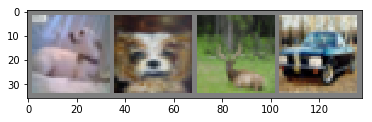

In [12]:
# Объявляем вектор, содержащий названия всех классов изображений
classes   = ( 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' )
# Объявляем итератор по всему тестовому dataset'y
data_iter = iter( test_loader )
# Считываем изображение и разметку.
images, labels = data_iter.next()
# Выводим изображение на экран
imshow( torchvision.utils.make_grid( images ) ) 
# Выводим соответствующие классы
print( 'GroundTruth: ', ' '.join( '%s' % classes[labels[j]] for j in range( BATCH_SIZE ) ))

In [14]:
# Запускаем нейросеть на первых BATCH_SIZE изображениях из тестовой выборки
outputs = cnn( images )
_, predicted = torch.max( outputs, 1 )
print( "Predicted: ", ' '.join( '%s' % classes[predicted[j]] for j in range ( BATCH_SIZE ) ) )

Predicted:  truck frog deer automobile


In [15]:
# Напишем функцию оценки точности работы получившейся сети

class_correct = list( 0. for i in range(10) )                     # Выделим нулевой вектор размера 10 (количество классов)
                                                                  # для весов корректно распознанных классов
class_total   = list( 0. for i in range(10) )                     # -- || -- для общих весов классов
with torch.no_grad():                                             # Указываем на то, что градиент не используется
    for data in test_loader:                                      # Для всех изображений тестового dataset'a
        images, labels = data                                     # Получаем текущие изображение и разметку
        outputs = cnn( images )                                   # Применяем нейронную сеть к изображению
        _, predicted = torch.max( outputs, 1 )                    
        c = ( predicted == labels ).squeeze()
        for i in range( BATCH_SIZE ):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

In [16]:
for i in range(10):
    print( 'Accuracy of %s : %d %%' % (classes[i], 100 * class_correct[i] / class_total[i] ) )


Accuracy of airplane : 47 %
Accuracy of automobile : 91 %
Accuracy of bird : 26 %
Accuracy of cat : 48 %
Accuracy of deer : 7 %
Accuracy of dog : 26 %
Accuracy of frog : 70 %
Accuracy of horse : 50 %
Accuracy of ship : 21 %
Accuracy of truck : 57 %
